<h2 align="center">Codebasics DL Course: Vehicle Damage Detection Project</h2>

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

### Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2664

In [6]:
2664*0.8

2131.2000000000003

In [7]:
class_names = dataset.classes
class_names 

['F_Breakage',
 'F_Crushed',
 'F_Normal',
 'R_Breakage',
 'R_Crushed',
 'R_Normal',
 'S_Damaged',
 'S_Normal']

In [8]:
num_classes = len(dataset.classes)
num_classes

8

In [9]:
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(2131, 533)

In [10]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
labels[1]

tensor(4)

In [14]:
images[1].shape

torch.Size([3, 224, 224])

In [15]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


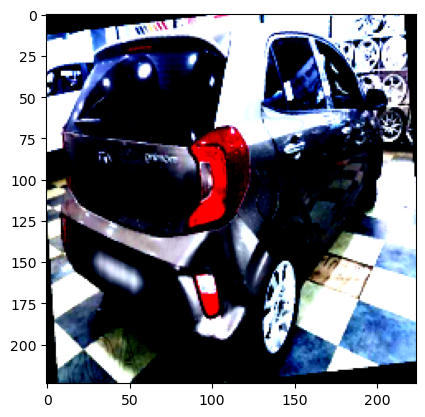

In [16]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

### Model 1: CNN

In [17]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [18]:
images.size(0)

32

In [19]:
len(train_loader.dataset)

2131

In [20]:
def train_model(model, criterion, optimizer, epochs=10):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [21]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 2.11
Batch: 20, Epoch: 1, Loss: 2.08
Batch: 30, Epoch: 1, Loss: 1.95
Batch: 40, Epoch: 1, Loss: 1.87
Batch: 50, Epoch: 1, Loss: 1.79
Batch: 60, Epoch: 1, Loss: 1.63
Epoch [1/10], Avg Loss: 2.1792
*** Validation Accuracy: 37.15% ***
Batch: 10, Epoch: 2, Loss: 1.17
Batch: 20, Epoch: 2, Loss: 1.39
Batch: 30, Epoch: 2, Loss: 1.14
Batch: 40, Epoch: 2, Loss: 1.27
Batch: 50, Epoch: 2, Loss: 1.39
Batch: 60, Epoch: 2, Loss: 1.14
Epoch [2/10], Avg Loss: 1.3679
*** Validation Accuracy: 51.03% ***
Batch: 10, Epoch: 3, Loss: 1.22
Batch: 20, Epoch: 3, Loss: 1.46
Batch: 30, Epoch: 3, Loss: 1.39
Batch: 40, Epoch: 3, Loss: 0.94
Batch: 50, Epoch: 3, Loss: 1.57
Batch: 60, Epoch: 3, Loss: 1.18
Epoch [3/10], Avg Loss: 1.1391
*** Validation Accuracy: 55.35% ***
Batch: 10, Epoch: 4, Loss: 0.87
Batch: 20, Epoch: 4, Loss: 1.29
Batch: 30, Epoch: 4, Loss: 1.10
Batch: 40, Epoch: 4, Loss: 1.11
Batch: 50, Epoch: 4, Loss: 0.99
Batch: 60, Epoch: 4, Loss: 0.76
Epoch [4/10], Avg Loss: 0.9914


### Model 2: CNN with Regularization

In [22]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [23]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=15)

Batch: 10, Epoch: 1, Loss: 11.58
Batch: 20, Epoch: 1, Loss: 5.96
Batch: 30, Epoch: 1, Loss: 2.54
Batch: 40, Epoch: 1, Loss: 1.92
Batch: 50, Epoch: 1, Loss: 1.82
Batch: 60, Epoch: 1, Loss: 1.76
Epoch [1/15], Avg Loss: 6.9046
*** Validation Accuracy: 29.46% ***
Batch: 10, Epoch: 2, Loss: 2.05
Batch: 20, Epoch: 2, Loss: 1.69
Batch: 30, Epoch: 2, Loss: 1.80
Batch: 40, Epoch: 2, Loss: 1.75
Batch: 50, Epoch: 2, Loss: 1.71
Batch: 60, Epoch: 2, Loss: 2.06
Epoch [2/15], Avg Loss: 1.8432
*** Validation Accuracy: 29.27% ***
Batch: 10, Epoch: 3, Loss: 1.40
Batch: 20, Epoch: 3, Loss: 1.65
Batch: 30, Epoch: 3, Loss: 1.90
Batch: 40, Epoch: 3, Loss: 1.61
Batch: 50, Epoch: 3, Loss: 1.84
Batch: 60, Epoch: 3, Loss: 1.72
Epoch [3/15], Avg Loss: 1.7841
*** Validation Accuracy: 33.77% ***
Batch: 10, Epoch: 4, Loss: 1.69
Batch: 20, Epoch: 4, Loss: 1.88
Batch: 30, Epoch: 4, Loss: 1.59
Batch: 40, Epoch: 4, Loss: 1.81
Batch: 50, Epoch: 4, Loss: 1.79
Batch: 60, Epoch: 4, Loss: 1.73
Epoch [4/15], Avg Loss: 1.7091

### Model 3: Transfer Learning with EfficientNet

In [24]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [25]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [26]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.82
Batch: 20, Epoch: 1, Loss: 1.64
Batch: 30, Epoch: 1, Loss: 1.44
Batch: 40, Epoch: 1, Loss: 1.42
Batch: 50, Epoch: 1, Loss: 1.36
Batch: 60, Epoch: 1, Loss: 1.16
Epoch [1/10], Avg Loss: 1.5405
*** Validation Accuracy: 62.29% ***
Batch: 10, Epoch: 2, Loss: 1.31
Batch: 20, Epoch: 2, Loss: 1.02
Batch: 30, Epoch: 2, Loss: 1.08
Batch: 40, Epoch: 2, Loss: 0.96
Batch: 50, Epoch: 2, Loss: 1.02
Batch: 60, Epoch: 2, Loss: 1.14
Epoch [2/10], Avg Loss: 1.0638
*** Validation Accuracy: 66.79% ***
Batch: 10, Epoch: 3, Loss: 0.92
Batch: 20, Epoch: 3, Loss: 1.00
Batch: 30, Epoch: 3, Loss: 1.00
Batch: 40, Epoch: 3, Loss: 1.20
Batch: 50, Epoch: 3, Loss: 1.02
Batch: 60, Epoch: 3, Loss: 0.90
Epoch [3/10], Avg Loss: 0.9338
*** Validation Accuracy: 66.79% ***
Batch: 10, Epoch: 4, Loss: 0.84
Batch: 20, Epoch: 4, Loss: 0.94
Batch: 30, Epoch: 4, Loss: 0.76
Batch: 40, Epoch: 4, Loss: 0.74
Batch: 50, Epoch: 4, Loss: 0.77
Batch: 60, Epoch: 4, Loss: 0.81
Epoch [4/10], Avg Loss: 0.8438


### Model 4: Transfer Learning with ResNet

In [27]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [28]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.88
Batch: 20, Epoch: 1, Loss: 0.96
Batch: 30, Epoch: 1, Loss: 0.65
Batch: 40, Epoch: 1, Loss: 0.58
Batch: 50, Epoch: 1, Loss: 0.67
Batch: 60, Epoch: 1, Loss: 0.69
Epoch [1/10], Avg Loss: 0.8347
*** Validation Accuracy: 74.30% ***
Batch: 10, Epoch: 2, Loss: 0.40
Batch: 20, Epoch: 2, Loss: 0.38
Batch: 30, Epoch: 2, Loss: 0.25
Batch: 40, Epoch: 2, Loss: 0.36
Batch: 50, Epoch: 2, Loss: 0.36
Batch: 60, Epoch: 2, Loss: 0.29
Epoch [2/10], Avg Loss: 0.4068
*** Validation Accuracy: 76.55% ***
Batch: 10, Epoch: 3, Loss: 0.31
Batch: 20, Epoch: 3, Loss: 0.21
Batch: 30, Epoch: 3, Loss: 0.52
Batch: 40, Epoch: 3, Loss: 0.55
Batch: 50, Epoch: 3, Loss: 0.32
Batch: 60, Epoch: 3, Loss: 0.59
Epoch [3/10], Avg Loss: 0.3183
*** Validation Accuracy: 78.05% ***
Batch: 10, Epoch: 4, Loss: 0.22
Batch: 20, Epoch: 4, Loss: 0.26
Batch: 30, Epoch: 4, Loss: 0.18
Batch: 40, Epoch: 4, Loss: 0.11
Batch: 50, Epoch: 4, Loss: 0.27
Batch: 60, Epoch: 4, Loss: 0.10
Epoch [4/10], Avg Loss: 0.2127


#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.29231861632437395 (2) Learning Rate = 0.0024012311531690475

So now let's train the model once again with these best parameters

In [60]:
import copy
from sklearn.metrics import classification_report
import numpy as np

model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.29231861632437395).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0024012311531690475)

best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0
patience = 4
epochs = 10
trigger_times = 0

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = (100.0 * running_corrects.float() / total).item()

    # -------------------- Validation --------------------
    model.eval()
    val_running_corrects, val_total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)

    val_acc = (100.0 * val_running_corrects.float() / val_total).item()

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Acc: {val_acc:.2f}%")

    # ------------------ Early Stopping ------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        print("✅ Best model updated based on validation accuracy.")
    
        # Capture predictions & labels exactly at this best epoch
        best_preds = []
        best_labels = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                best_preds.extend(preds.cpu().numpy())
                best_labels.extend(labels.cpu().numpy())
            
    else:
        trigger_times += 1
        print(f"⏳ No improvement. Early stop counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("⛔ Early stopping triggered.")
            break

# Load best weights and save model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'saved_model.pth')
print(f"📦 Best model saved with validation accuracy: {best_val_acc:.2f}%")

Epoch 1/10 - Train Loss: 0.8233 - Train Acc: 68.65% - Val Acc: 69.23%
✅ Best model updated based on validation accuracy.
Epoch 2/10 - Train Loss: 0.4574 - Train Acc: 81.75% - Val Acc: 74.30%
✅ Best model updated based on validation accuracy.
Epoch 3/10 - Train Loss: 0.3195 - Train Acc: 88.08% - Val Acc: 76.55%
✅ Best model updated based on validation accuracy.
Epoch 4/10 - Train Loss: 0.2238 - Train Acc: 92.07% - Val Acc: 77.30%
✅ Best model updated based on validation accuracy.
Epoch 5/10 - Train Loss: 0.2038 - Train Acc: 93.38% - Val Acc: 76.74%
⏳ No improvement. Early stop counter: 1/4
Epoch 6/10 - Train Loss: 0.1483 - Train Acc: 94.51% - Val Acc: 78.99%
✅ Best model updated based on validation accuracy.
Epoch 7/10 - Train Loss: 0.0927 - Train Acc: 96.86% - Val Acc: 78.05%
⏳ No improvement. Early stop counter: 1/4
Epoch 8/10 - Train Loss: 0.0897 - Train Acc: 97.04% - Val Acc: 78.61%
⏳ No improvement. Early stop counter: 2/4
Epoch 9/10 - Train Loss: 0.0988 - Train Acc: 96.43% - Val A

### Model Evaluation using Confusion Matrix and Classification Report

In [61]:
from sklearn.metrics import classification_report

report = classification_report(best_labels, best_preds, digits=2)
print("\n📊 Classification Report:\n")
print(report)


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       107
           1       0.84      0.63      0.72        81
           2       0.88      0.90      0.89       102
           3       0.75      0.73      0.74        63
           4       0.56      0.68      0.62        53
           5       0.87      0.71      0.78        58
           6       0.95      0.97      0.96        36
           7       0.97      0.97      0.97        33

    accuracy                           0.80       533
   macro avg       0.82      0.81      0.81       533
weighted avg       0.81      0.80      0.80       533



/var/folders/dw/8xmb3tsd1j97gg1p6nfz7vk00000gn/T/ipykernel_95141/605965671.py:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/torch_mps/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


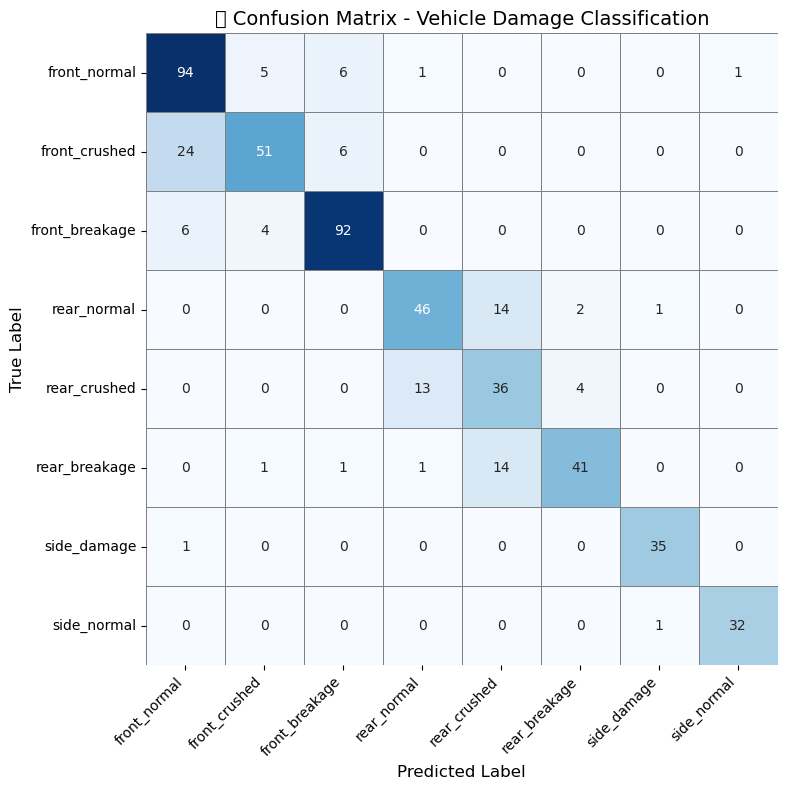

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Class names
class_names = [
    "front_normal",
    "front_crushed",
    "front_breakage",
    "rear_normal",
    "rear_crushed",
    "rear_breakage",
    "side_damage",
    "side_normal"
]
class_names = class_names[:len(np.unique(best_labels))]  # In case you have 7 instead of 8 classes

# Confusion matrix
cm = confusion_matrix(best_labels, best_preds, labels=np.arange(len(class_names)))

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray', square=True, cbar=False)

plt.title("🔍 Confusion Matrix - Vehicle Damage Classification", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
